In [1]:
import random, os, functools, statistics

import numpy as np
import matplotlib.pyplot as plt
import dill, joblib

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import v2
from torch.utils.data import DataLoader

from glio.train2 import *
from glio.train2.cbs_summary import Summary
from glio.visualize import vis_imshow, vis_imshow_grid, Visualizer
from glio.jupyter_tools import show_slices, show_slices_arr, clean_mem
from glio.torch_tools import area_around, one_hot_mask, summary, lr_finder, to_binary, count_parameters
from glio.python_tools import type_str, CacheRepeatIterator, get_all_files
from glio import nn as gnn
from glio.nn import conv, convt, linear, seq, block
from glio.data import DSToTarget
from glio.helpers import cnn_output_size, tcnn_output_size
from glio.loaders import nifti
from glio.transforms import fToChannels, fToChannelsFirst,fToChannelsLast, z_normalize, norm_to01

from monai.losses.dice import DiceLoss, DiceFocalLoss
from monai.metrics import MeanIoU, SurfaceDiceMetric, DiceHelper # type:ignore
from schedulefree import AdamWScheduleFree

inp.shape = torch.Size([13, 96, 96]), target.shape = torch.Size([4, 96, 96])
[i.mean() for i in inp] = [tensor(-1.9154), tensor(-1.8024), tensor(-1.0965), tensor(-0.5120), tensor(1.0204), tensor(1.1879), tensor(-0.7943), tensor(0.2186), tensor(-0.8365), tensor(0.9025), tensor(0.), tensor(0.0628), tensor(0.)], [i.std() for i in inp] = [tensor(3.1094), tensor(3.0984), tensor(2.8888), tensor(2.5523), tensor(0.9315), tensor(0.2930), tensor(0.2168), tensor(0.3779), tensor(0.2041), tensor(0.2967), tensor(0.), tensor(0.2427), tensor(0.)]
ds.get_preloaded_percent() = 1.0
len(ds) = 7784
len(dstrain) = 7005, len(dstest) = 779


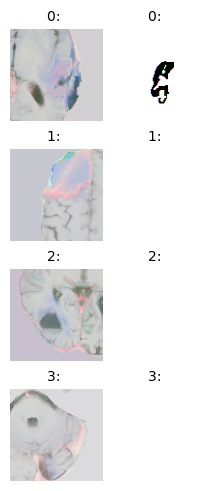

In [2]:
TITLE = "RHUH 2D segm refining"
PRELOAD = 1.0

def get_center(npz):
    return (npz["center"][1], npz["center"][0])
def loader(path: str):
    npz = np.load(path)
    imgs = npz["img"][:4]
    ads = z_normalize(npz["img"][4])
    return (
        area_around(torch.cat(
                [
                    torch.from_numpy(imgs),
                    torch.from_numpy(ads).unsqueeze(0),
                    z_normalize(torch.from_numpy(npz["preds"])),
                    torch.from_numpy(npz["preds_binary"]),
                ], 0,), get_center(npz), (96, 96)).to(torch.float16),
        area_around(one_hot_mask(torch.from_numpy(npz["seg"]), 4), get_center(npz), (96, 96))
    )

# torch.Size([13, 96, 96])
# torch.Size([4, 96, 96])

def tfm_input(data):
    return data[0].to(torch.float32)

def tfm_target(data):
    return data[1]

img = loader(r"E:\dataset\RHUH-GBM 2D\images\RHUH-0001\1\RHUH-0001_1_64.npz")
inp = tfm_input(img)
target = tfm_target(img)

print(f"{inp.shape = }, {target.shape = }")
print(f"{[i.mean() for i in inp] = }, {[i.std() for i in inp] = }")

# ds = DSToTarget()
# ds.add_folder(r"E:\dataset\RHUH-GBM 2D\images", loader, None, tfm_input, tfm_target)
# ds.preload(PRELOAD, True)

ds:DSToTarget = joblib.load(r"F:\Stuff\Programming\experiments\ai\RHUH 2d refine preloaded ds.joblib")
print(f"{ds.get_preloaded_percent() = }")
print(f"{len(ds) = }")
dstrain, dstest = ds.split(0.5)
print(f"{len(dstrain) = }, {len(dstest) = }")
dstrain.preview()

def plot_preds(learner:Learner, batch, softmax = True, unsqueeze = True):
    batch = list(batch)
    if unsqueeze:
        batch[0] = batch[0].unsqueeze(0)
        batch[1] = batch[1].unsqueeze(0)
    preds = learner.inference(batch[0])
    v = Visualizer()
    v.imshow_grid(batch[0][0], mode="bhw", label="вход")
    v.imshow_grid(batch[1][0], mode="bhw", label = "реальная карта")
    if softmax:
        output = torch.stack([preds[0],preds[0],preds[0]], dim=1)
        output[:,0] *=  F.softmax(preds[0],0)
        v.imshow_grid(output, mode="bchw", label="сырой выход")
        v.imshow_grid(to_binary(F.softmax(preds[0], 0)), mode="bhw", label="предсказанная карта")
    else:
        v.imshow_grid(preds[0], mode="bchw", label="сырой выход")
        v.imshow_grid(to_binary(preds[0], 0), mode="bhw", label="предсказанная карта")
    v.show(figsize=(24, 24), nrows=1)

def eval_on_brats_2d(learner: Learner, folder):
    """inputs, targets, preds, preds_softmax, preds_binary, preds_binary_softmax"""
    images = [loader(i) for i in get_all_files(folder)]
    inputs = torch.stack([tfm_input(i) for i in images])
    targets = torch.stack([tfm_target(i) for i in images])
    preds = learner.inference(inputs)
    preds_softmax = F.softmax(preds, 0)
    preds_binary = to_binary(preds_softmax)
    preds_binary_softmax = to_binary(preds)
    t1 = torch.cat([norm_to01(inputs), norm_to01(targets), norm_to01(preds)], 3)
    t2 = torch.cat([norm_to01(preds_softmax), norm_to01(preds_binary), norm_to01(preds_binary_softmax)], 3)
    t = torch.cat([t1, t2], 2)
    show_slices(t)
    
def find_file_containing(folder, contains:str, recursive = True):
    for f in get_all_files(folder, recursive=recursive):
        if contains in f:
            return f
    raise FileNotFoundError(f"No file containing {contains} in {folder}")


from monai.inferers import SlidingWindowInfererAdapt # type:ignore
def eval_on_rhuh_slices(learner: Learner, folder):
    """inputs, targets, preds, preds_softmax, preds_binary, preds_binary_softmax"""
    t1c = z_normalize(nifti.read(find_file_containing(folder, "t1ce")))
    t1n = z_normalize(nifti.read(find_file_containing(folder, "t1.")))
    t2f = z_normalize(nifti.read(find_file_containing(folder, "flair")))
    t2w = z_normalize(nifti.read(find_file_containing(folder, "t2")))
    seg = one_hot_mask(nifti.read(find_file_containing(folder, "seg")), 4).swapaxes(0,1)

    inputs = torch.stack([t1c, t1n, t2f, t2w]).swapaxes(0,1)
    inferer = SlidingWindowInfererAdapt(roi_size = (96,96), sw_batch_size = 32)
    preds = inferer(inputs, learner.inference)
    

    preds_softmax = F.softmax(preds, 0) # type:ignore
    preds_binary = to_binary(preds_softmax)
    preds_binary_softmax = to_binary(preds)# type:ignore
    t1 = torch.cat([norm_to01(inputs), norm_to01(seg), norm_to01(preds)], 3)
    t2 = torch.cat([norm_to01(preds_softmax), norm_to01(preds_binary), norm_to01(preds_binary_softmax)], 3)
    t = torch.cat([norm_to01(t1), norm_to01(t2)], 2)
    show_slices(norm_to01(t))
    
def eval_on_brats_slices(learner: Learner, folder):
    """inputs, targets, preds, preds_softmax, preds_binary, preds_binary_softmax"""
    t1c = z_normalize(nifti.read(find_file_containing(folder, "t1c")))
    t1n = z_normalize(nifti.read(find_file_containing(folder, "t1n")))
    t2f = z_normalize(nifti.read(find_file_containing(folder, "t2f")))
    t2w = z_normalize(nifti.read(find_file_containing(folder, "t2w")))
    seg = one_hot_mask(nifti.read(find_file_containing(folder, "seg")), 4).swapaxes(0,1)

    inputs = torch.stack([t1c, t1n, t2f, t2w]).swapaxes(0,1)
    inferer = SlidingWindowInfererAdapt(roi_size = (96,96), sw_batch_size = 32)
    preds = inferer(inputs, learner.inference)
    

    preds_softmax = F.softmax(preds, 0) # type:ignore
    preds_binary = to_binary(preds_softmax)
    preds_binary_softmax = to_binary(preds)# type:ignore
    t1 = torch.cat([norm_to01(inputs), norm_to01(seg), norm_to01(preds)], 3)
    t2 = torch.cat([norm_to01(preds_softmax), norm_to01(preds_binary), norm_to01(preds_binary_softmax)], 3)
    t = torch.cat([norm_to01(t1), norm_to01(t2)], 2)
    show_slices(norm_to01(t))
    
    
def eval_on_brats_slices_sep_arr(learner: Learner, folder):
    """inputs, targets, preds, preds_softmax, preds_binary, preds_binary_softmax"""
    t1c = z_normalize(nifti.read(find_file_containing(folder, "t1c")).to(torch.float32))
    t1n = z_normalize(nifti.read(find_file_containing(folder, "t1n")).to(torch.float32))
    t2f = z_normalize(nifti.read(find_file_containing(folder, "t2f")).to(torch.float32))
    t2w = z_normalize(nifti.read(find_file_containing(folder, "t2w")).to(torch.float32))
    seg = one_hot_mask(nifti.read(find_file_containing(folder, "seg")), 4).swapaxes(0,1)

    inputs = torch.stack([t1c, t1n, t2f, t2w]).swapaxes(0,1)
    inferer = SlidingWindowInfererAdapt(roi_size = (96,96), sw_batch_size = 32, overlap=0.1)
    preds = inferer(inputs, learner.inference)
    

    preds_softmax = F.softmax(preds, 0) # type:ignore
    preds_binary = to_binary(preds_softmax)
    preds_binary_softmax = to_binary(preds)# type:ignore
    show_slices_arr(torch.stack([inputs, seg, preds, preds_softmax, preds_binary, preds_binary_softmax]))

In [3]:
from monai.networks.nets import SegResNetDS#type:ignore
cpath = r"F:\Stuff\Programming\experiments\ai\RHUH 2D segm refining\SegResNetDS lr=0.001 bs=64 loss = monai.losses.dice.DiceFocalLoss opt=AdamWScheduleFree sch=NoneType\1. 08.04.2024 17-31-58 (168-18496; testloss=0.05901)"
MODEL = SegResNetDS(2, in_channels=13, out_channels=4, init_filters=24)
LR = 1e-2

OPT = AdamWScheduleFree(MODEL.parameters(), lr=LR, eps=1e-6)
LOSS_FN = DiceFocalLoss(softmax=True)
l = Learner.from_checkpoint(cpath, MODEL, [Accelerate("no")], optimizer=OPT)
l.fit(0, None, None)

In [38]:
# MODEL = SegResNetDS(2, in_channels=13, out_channels=4, init_filters=24)
NAME = f"{MODEL.__class__.__name__} metrics"
LR = 1e-3
BATCH_SIZE = 64
N_EPOCHS = 100

# dl_train = DataLoader(ds_train, BATCH_SIZE)
dltrain = DataLoader(dstrain, BATCH_SIZE, shuffle=True)
dltest = DataLoader(dstest, BATCH_SIZE)

# OPT = AdamWScheduleFree(MODEL.parameters(), lr=LR, eps=1e-6)
LOSS_FN = DiceFocalLoss(softmax=True)
SCHED = None

clean_mem()

from monai import metrics # type:ignore

def accuracy_seg(x, y):
    x = to_binary(F.softmax(x[:,1:], 1))
    return (x == y[:,1:]).to(torch.float32).mean()

targets = []
preds = []

from glio.design.EventModel import CBMethod
class Save_Preds_targets(CBMethod):
    def __init__(self):
        super().__init__()
    def after_batch(self, learner:Learner):
        preds.append(F.softmax(learner.preds[:,1:], 1))
        targets.append(learner.targets[:,1:])

LEARNER_NAME = f"{NAME} metrics"
learner = Learner(MODEL, LEARNER_NAME,
                  cbs = (Metric_Loss(), # Log_GradHistorgram(16), Log_SignalHistorgram(16),
                         Log_Time(), Save_Best(TITLE), Save_Last(TITLE), Log_LR(), Summary(), Accelerate("no"),
                         Metric_PredsTargetsFn(DiceLoss(softmax=True), step=4),
                         FastProgressBar(plot=False),
                         Metric_PredsTargetsFn(lambda x,y:metrics.compute_iou(to_binary(F.softmax(x[:,1:], 1)), y[:,1:]).nanmean()), # type:ignore
                         #Metric_PredsTargetsFn(lambda x,y:metrics.compute_roc_auc(F.softmax(x, 0), y).nanmean()), # type:ignore
                         Metric_PredsTargetsFn(accuracy_seg), # type:ignore
                         Save_Preds_targets()

                         ),
                  loss_fn=LOSS_FN,
                  optimizer=OPT,
                  scheduler=SCHED,)
learner.fit(1, None, dltest, test_first=False)

plt.show()

test loss: min: 0.0174; max: 0.0174; last: 0.0174
test fn - monai.losses.dice.DiceLoss: min: 0.0139; max: 0.0139; last: 0.0139
test fn - <lambda>: min: 0.2120; max: 0.2120; last: 0.2120
test fn - accuracy_seg: min: 0.7082; max: 0.7082; last: 0.7082


In [40]:
targets = torch.stack(targets[:-1])
preds = torch.stack(preds[:-1])

vt = targets.ravel()
vp = preds.ravel()
vt.shape, vp.shape

TypeError: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

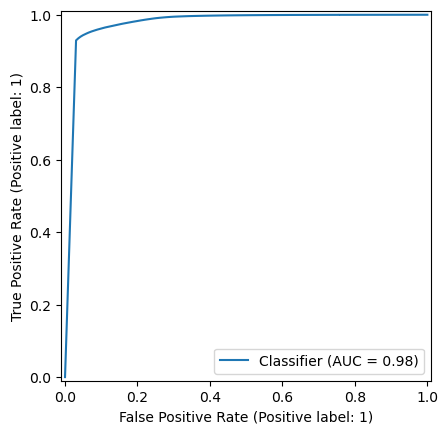

In [41]:
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, PrecisionRecallDisplay

r = RocCurveDisplay.from_predictions(np.array(vt.cpu().int(), dtype=int), vp.cpu())
plt.show()

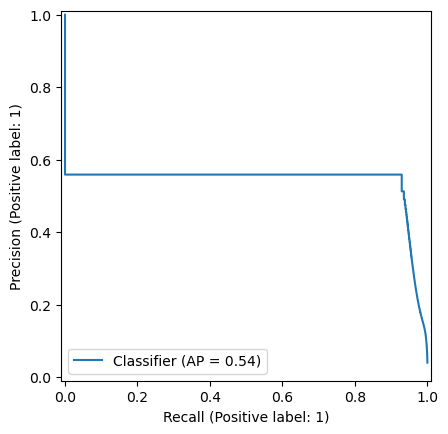

In [42]:
r = PrecisionRecallDisplay.from_predictions(np.array(vt.cpu().int(), dtype=int), vp.cpu())
plt.show()